In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

random.seed(33)

unique_name = "DistilBERT_Finetuned"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Twitter16_DistilBERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(818, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter16_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt,cv_fold,tt,tvt2
0,656955120626880512,correct predictions in back to the future ii U...,false,training,1,training,validation
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,true,training,3,training,training
2,613404935003217920,cops bought the alleged church shooter burger ...,false,training,2,test,training
3,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,training,3,test,training
4,714598641827246081,an open letter to trump voters from his top st...,unverified,training,1,test,training


In [4]:
labels_str = data['label'].unique().tolist()
labels_str

['false', 'true', 'unverified', 'non-rumor']

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
#     labels.append([1 if j == lab else 0 for j in range(len(labels_str))])
    labels.append(lab)
labels[:10]

[0, 1, 0, 2, 2, 1, 2, 3, 3, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(531, 768)
(185, 768)
(102, 768)
(531,)
(185,)
(102,)


In [8]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNClassifier(nn.Module):
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Linear(128, n_output),
#             nn.Sigmoid()
        )
        self.criterion = criterion()
        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

    def forward(self, input):
        return self.model(input)
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        best_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
                
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())

                test_loss += loss.item()
                
                preds = self.predict(test_x)
                conf_mat = ConfusionMatrix(
                    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    binary=False
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [9]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from library.classification import SKLearnClassification
from library.evaluation import ConfusionMatrix

dataset_name = "Twitter16"

logres_model = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr', max_iter=10000)
neigh = KNeighborsClassifier(n_neighbors=3)
svm = LinearSVC()

models = [
    SKLearnClassification(logres_model, "Logistic Regression"),
    SKLearnClassification(neigh, "K-Nearest Neighbor"),
    SKLearnClassification(svm, "Support Vector Machine"),
]
# for model in models:
#     print(f"\n--- {model.model_name.upper()} ---")
#     model.train(train_vectors, train_labels, dataset_name)
    
#     print("Validation Set")
#     preds = model.predict(val_vectors)

#     conf_mat = ConfusionMatrix(
#         labels=val_labels,
#         predictions=preds,
#         binary=True
#     )
#     conf_mat.evaluate()
    
#     print("Test Set")
#     preds = model.predict(test_vectors)

#     conf_mat = ConfusionMatrix(
#         labels=test_labels,
#         predictions=preds,
#         binary=False
#     )
#     conf_mat.evaluate(classes=labels_str)

#     print("--- END ---\n")

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 56.216
Saving after new best accuracy : 76.757
Saving after new best accuracy : 78.919
Saving after new best accuracy : 79.459
Saving after new best accuracy : 80.0
-- Epoch 50, Train Loss : 0.0009022081503644586, Test Loss : 1.0214052200317383
-- Epoch 100, Train Loss : 0.0002144013560609892, Test Loss : 1.177476167678833
-- Epoch 150, Train Loss : 9.470317672821693e-05, Test Loss : 1.268017292022705
-- Epoch 200, Train Loss : 5.328875340637751e-05, Test Loss : 1.3324511051177979
-- Epoch 250, Train Loss : 3.406717769394163e-05, Test Loss : 1.3824588060379028
-- Epoch 300, Train Loss : 2.3632662305317353e-05, Test Loss : 1.423534631729126
-- Epoch 350, Train Loss : 1.732579085000907e-05, Test Loss : 1.4584376811981201
-- Epoch 400, Train Loss : 1.3255048997962149e-05, Test Loss : 1.488782286643982
-- Epoch 450, Train Loss : 1.0408933121652808e-05, Test Loss : 1.515809416770935
-- Epoch 5

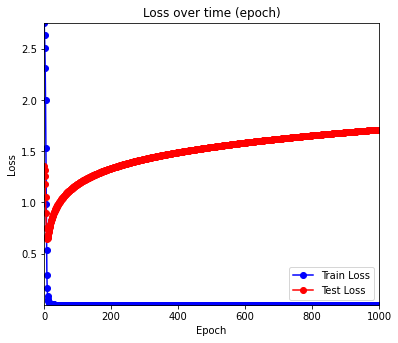

Exec Time : 31.34 seconds

Validation Set
Predictions : torch.Size([185])
185 vs 185
Multi Class Evaluation

Class false Evaluation
- Precision : 81.818 %
- Recall : 70.588 %
- F1 : 0.75789

Class true Evaluation
- Precision : 97.059 %
- Recall : 94.286 %
- F1 : 0.95652

Class unverified Evaluation
- Precision : 74.074 %
- Recall : 81.633 %
- F1 : 0.7767

Class non-rumor Evaluation
- Precision : 73.585 %
- Recall : 78.0 %
- F1 : 0.75728

Combined Evaluation
- Accuracy : 80.0 %
- Precision : 81.634 %
- Recall : 81.127 %
- F1 : 0.8138

- Average Confidence : 100.0 %
Model, Combined,,,,false,,,true,,,unverified,,,non-rumor,,,
Twitter16_4LayerNet_DistilBERT_Finetuned Validation, 80.0, 81.634, 81.127, 0.8138, 81.818, 70.588, 0.75789, 97.059, 94.286, 0.95652, 74.074, 81.633, 0.7767, 73.585, 78.0, 0.75728, 

Test Set
Predictions : torch.Size([102])
102 vs 102
Multi Class Evaluation

Class false Evaluation
- Precision : 75.0 %
- Recall : 77.778 %
- F1 : 0.76364

Class true Evaluation
- Precisi

In [10]:
print("Multiclass Classification using 4-Layer Linear Network")
start = time.time()
model_name = f"Twitter16_4LayerNet_{unique_name}"
model = NNClassifier(train_vectors.shape[1], n_output=4, criterion=nn.CrossEntropyLoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=512)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nValidation Set")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\nTest Set")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)